In [ ]:
# Import necessary tools for working with data and making plots
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Tools for machine learning (splitting data, scaling, models, evaluating)
from sklearn.model_selection import train_test_split, cross_val_score, StratifiedKFold
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, roc_curve

# Make plots look nice
sns.set_style("whitegrid")

In [ ]:
# Load the Titanic dataset
df = pd.read_csv("titanic.csv")
print("Loaded dataset with shape:", df.shape)
display(df.head()) # Show the first few rows

Loaded dataset with shape: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [ ]:
# Get basic info about the data and check for missing values
print("\nInfo:")
df.info()
print("\nMissing values:\n", df.isnull().sum())


Info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB

Missing values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked  

/tmp/ipython-input-80967908.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.countplot(data=df, x='Survived', palette='pastel')


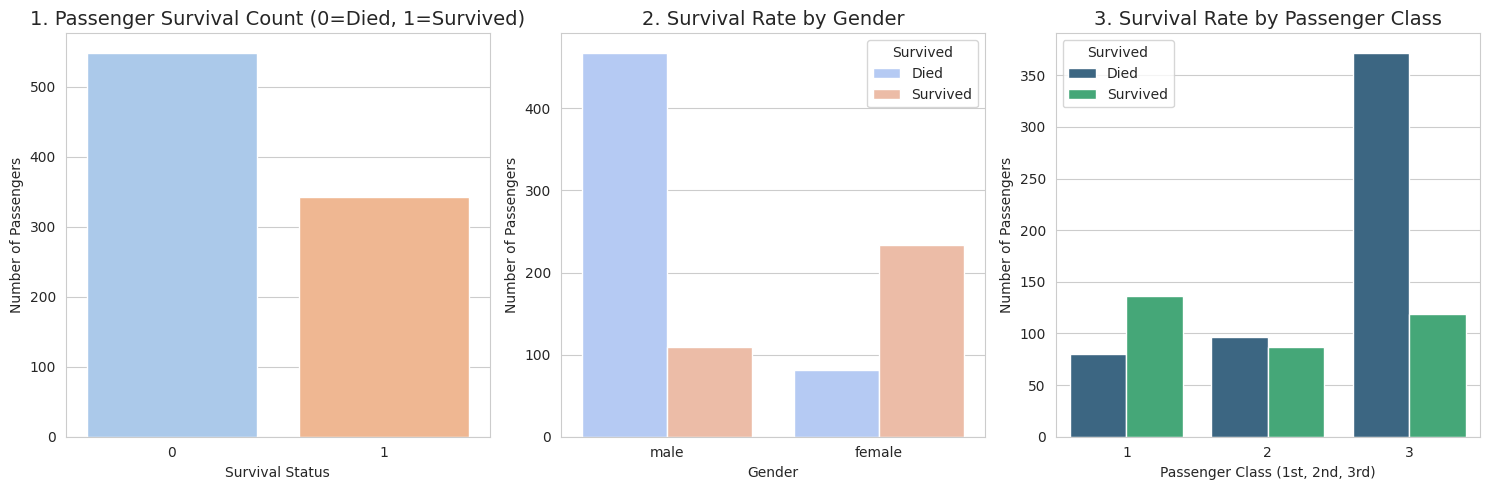

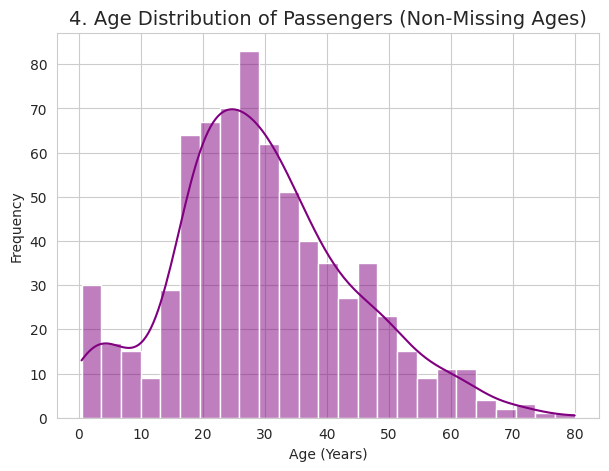

In [ ]:
# Make some plots to explore the data (EDA)
plt.figure(figsize=(15, 5))

# Plot 1: How many people survived vs. died
plt.subplot(1, 3, 1)
sns.countplot(data=df, x='Survived', palette='pastel')
plt.title("1. Passenger Survival Count (0=Died, 1=Survived)", fontsize=14)
plt.xlabel("Survival Status")
plt.ylabel("Number of Passengers")

# Plot 2: Survival based on gender
plt.subplot(1, 3, 2)
sns.countplot(data=df, x='Sex', hue='Survived', palette='coolwarm')
plt.title("2. Survival Rate by Gender", fontsize=14)
plt.xlabel("Gender")
plt.ylabel("Number of Passengers")
plt.legend(title='Survived', labels=['Died', 'Survived'])

# Plot 3: Survival based on passenger class
plt.subplot(1, 3, 3)
sns.countplot(data=df, x='Pclass', hue='Survived', palette='viridis')
plt.title("3. Survival Rate by Passenger Class", fontsize=14)
plt.xlabel("Passenger Class (1st, 2nd, 3rd)")
plt.ylabel("Number of Passengers")
plt.legend(title='Survived', labels=['Died', 'Survived'])

plt.tight_layout()
plt.show()

# Plot 4: Show how old the passengers are (distribution)
plt.figure(figsize=(7, 5))
sns.histplot(df['Age'].dropna(), bins=25, kde=True, color='purple')
plt.title("4. Age Distribution of Passengers (Non-Missing Ages)", fontsize=14)
plt.xlabel("Age (Years)")
plt.ylabel("Frequency")
plt.show()

In [ ]:
# Clean the data and create new features
# 1. Fill in missing ages with the middle age
df['Age'].fillna(df['Age'].median(), inplace=True)

# 2. Fill in missing embarkation points with the most common one
df['Embarked'].fillna(df['Embarked'].mode()[0], inplace=True)

# 3. Fill in any missing fares with the middle fare
if df['Fare'].isnull().any():
    df['Fare'].fillna(df['Fare'].median(), inplace=True)

# 4. Make a new feature for family size
df['FamilySize'] = df['SibSp'] + df['Parch'] + 1

# 5. Get the title (like Mr., Mrs., Miss) from the name and simplify some
df['Title'] = df['Name'].str.extract(r',\s*([^\.]+)\.', expand=False).str.strip()
df['Title'] = df['Title'].replace(['Lady','Countess','Capt','Col','Don','Dr','Major','Rev','Sir','Jonkheer','Dona'],'Rare')
df['Title'] = df['Title'].replace({'Mlle':'Miss','Ms':'Miss','Mme':'Mrs'})

# 6. Remove columns we don't need or have too much missing data
df.drop(['Cabin', 'Ticket', 'PassengerId', 'Name'], axis=1, inplace=True)

print("\nAfter cleaning, missing values:\n", df.isnull().sum())


After cleaning, missing values:
 Survived      0
Pclass        0
Sex           0
Age           0
SibSp         0
Parch         0
Fare          0
Embarked      0
FamilySize    0
Title         0
dtype: int64


/tmp/ipython-input-1165774251.py:3: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['Age'].fillna(df['Age'].median(), inplace=True)
/tmp/ipython-input-1165774251.py:6: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try 

In [ ]:
# Turn text categories into numbers (encode)
# Change 'male'/'female' to 0/1
df['Sex'] = df['Sex'].map({'male': 0, 'female': 1})

# Create separate columns for 'Embarked', 'Title', and 'Pclass' categories
df = pd.get_dummies(df, columns=['Embarked', 'Title', 'Pclass'], drop_first=True)

print("Columns after encoding:", df.columns.tolist())

Columns after encoding: ['Survived', 'Sex', 'Age', 'SibSp', 'Parch', 'Fare', 'FamilySize', 'Embarked_Q', 'Embarked_S', 'Title_Miss', 'Title_Mr', 'Title_Mrs', 'Title_Rare', 'Title_the Countess', 'Pclass_2', 'Pclass_3']


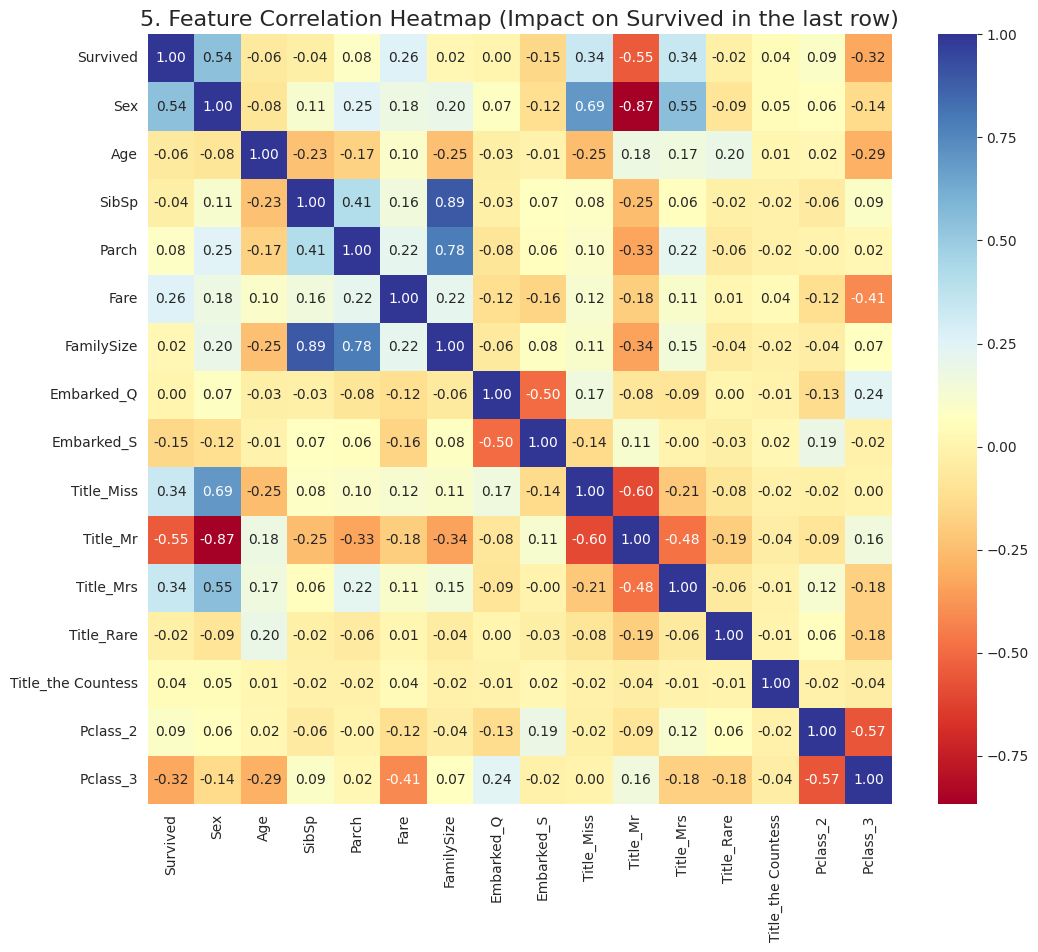

In [ ]:
# Show how features are related to each other (correlation heatmap)
plt.figure(figsize=(12,10))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap='RdYlBu')
plt.title("5. Feature Correlation Heatmap (Impact on Survived in the last row)", fontsize=16)
plt.show()

In [ ]:
# Prepare the data for the model (features and target)
X = df.drop('Survived', axis=1) # Features are all columns except 'Survived'
y = df['Survived'] # Target is the 'Survived' column

# Split data into training and testing sets (80% for training, 20% for testing)
# Stratify ensures the survival rate is similar in both sets
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

In [ ]:
# Build a model pipeline (scaler + logistic regression)
# Scaler makes all features have a similar range of values
# Logistic Regression is the model to predict survival

pipeline = Pipeline([
    ('scaler', StandardScaler()),
    ('clf', LogisticRegression(max_iter=1000, random_state=42))
])

# Check the model's accuracy using cross-validation
# This splits the training data into 5 parts and trains/tests 5 times
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)
cv_scores = cross_val_score(pipeline, X_train, y_train, cv=cv, scoring='accuracy')
print(f"\nCross-val accuracy (5-fold): mean={cv_scores.mean():.3f}, std={cv_scores.std():.3f}")

# Train the model on the training data
pipeline.fit(X_train, y_train)


Cross-val accuracy (5-fold): mean=0.816, std=0.028


Pipeline(steps=[('scaler', StandardScaler()),
                ('clf', LogisticRegression(max_iter=1000, random_state=42))])

In [ ]:
# Make predictions on the test data and evaluate the model
y_pred = pipeline.predict(X_test) # Predict survival (0 or 1)
y_proba = pipeline.predict_proba(X_test)[:, 1]  # Get survival probability

# Calculate and print evaluation metrics
acc = accuracy_score(y_test, y_pred)
roc_auc = roc_auc_score(y_test, y_proba)
print(f"\nTest Accuracy: {acc:.3f}")
print(f"Test ROC AUC: {roc_auc:.3f}")
print("\nClassification Report:\n", classification_report(y_test, y_pred))


Test Accuracy: 0.832
Test ROC AUC: 0.880

Classification Report:
               precision    recall  f1-score   support

           0       0.84      0.89      0.87       110
           1       0.81      0.74      0.77        69

    accuracy                           0.83       179
   macro avg       0.83      0.82      0.82       179
weighted avg       0.83      0.83      0.83       179



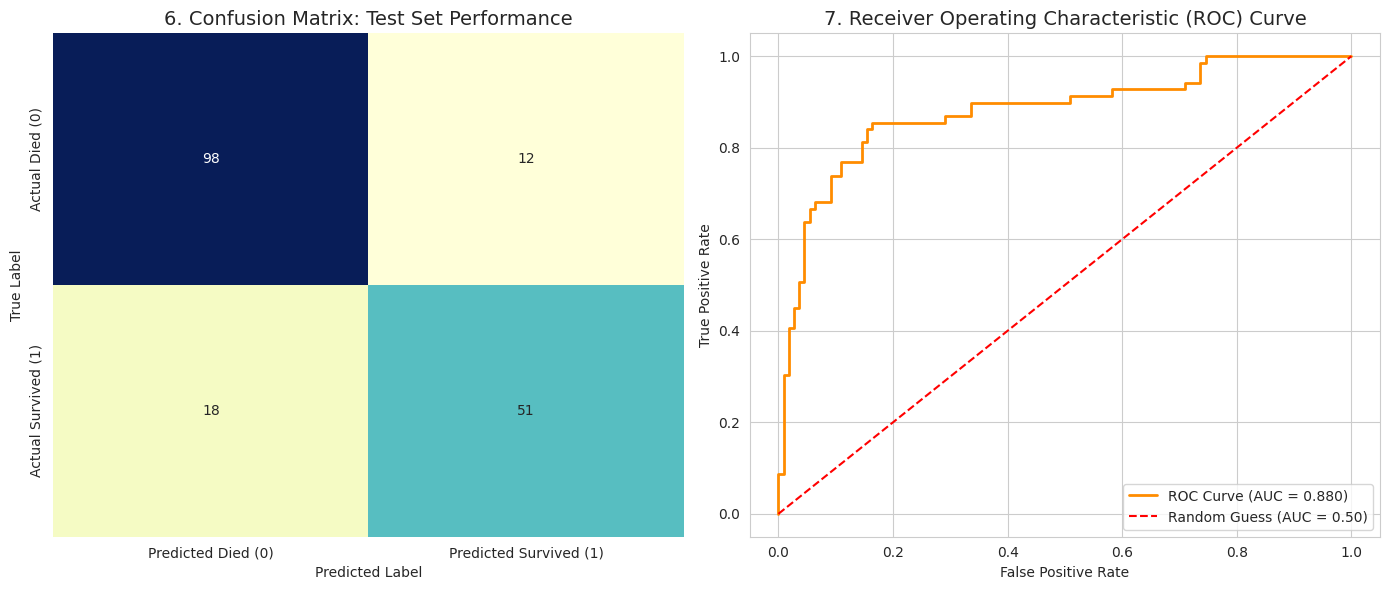

In [ ]:
# Make plots to visualize model performance
plt.figure(figsize=(14, 6))

# Plot 6: Confusion Matrix (shows correct and incorrect predictions)
plt.subplot(1, 2, 1)
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='YlGnBu', cbar=False,
            xticklabels=['Predicted Died (0)', 'Predicted Survived (1)'],
            yticklabels=['Actual Died (0)', 'Actual Survived (1)'])
plt.title("6. Confusion Matrix: Test Set Performance", fontsize=14)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")

# Plot 7: ROC Curve (shows how well the model distinguishes between classes)
plt.subplot(1, 2, 2)
fpr, tpr, thresholds = roc_curve(y_test, y_proba)
plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {roc_auc:.3f})', color='darkorange', linewidth=2)
plt.plot([0,1],[0,1],'r--', label='Random Guess (AUC = 0.50)')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('7. Receiver Operating Characteristic (ROC) Curve', fontsize=14)
plt.legend(loc='lower right')

plt.tight_layout()
plt.show()


Survival rate by age group:
         AgeGroup  Survived
0   Child (0-12)  0.579710
1   Teen (13-18)  0.428571
2  Adult (19-60)  0.365753
3   Senior (61+)  0.227273


/tmp/ipython-input-2887190468.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  survival_by_age = df.groupby('AgeGroup')['Survived'].mean().reset_index()
/tmp/ipython-input-2887190468.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=survival_by_age, x='AgeGroup', y='Survived', palette='tab10')


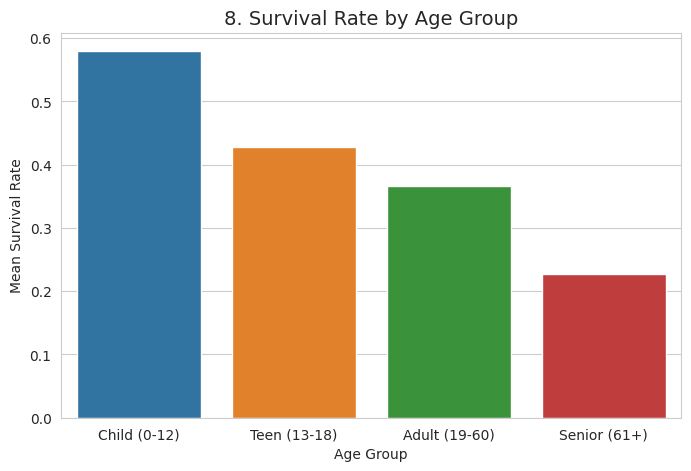

In [ ]:
# Bonus: Look at survival rates for different age groups
# Define age groups
bins = [0, 12, 18, 60, 120]  # children, teens, adults, seniors
labels = ['Child (0-12)', 'Teen (13-18)', 'Adult (19-60)', 'Senior (61+)']
df['AgeGroup'] = pd.cut(df['Age'], bins=bins, labels=labels, right=True)

# Calculate survival rate for each age group
survival_by_age = df.groupby('AgeGroup')['Survived'].mean().reset_index()
print("\nSurvival rate by age group:\n", survival_by_age)

# Plot 8: Bar plot of survival rate by age group
plt.figure(figsize=(8, 5))
sns.barplot(data=survival_by_age, x='AgeGroup', y='Survived', palette='tab10')
plt.ylabel("Mean Survival Rate")
plt.xlabel("Age Group")
plt.title("8. Survival Rate by Age Group", fontsize=14)
plt.show()

# Data Handling Assignment Report: Titanic Survival Analysis

# 1. What Data We Used
We looked at the Titanic dataset, which has info about the people on the ship, like if they survived, their ticket class, age, and gender.

# 2. What We Found (Looking at the Data)
We saw some big things that affected who survived:

Girls and Women Survived More: A lot more females survived (about 74%) compared to males (about 19%). This shows they likely followed the "women and children first" rule.

Rich vs. Poor: People in first class had the best chance of surviving, while those in third class had the lowest. Where you were on the ship and how much money you had really mattered.

Age Made a Difference (Extra Look): The youngest kids (0-12) had a really high survival rate. This probably means they were rescued first.

# 3. Tricky Parts When Cleaning Data 🧹
The hardest part was dealing with missing info:

Missing Ages: We filled in the missing ages with the most common age (the median) from everyone on board.

Missing Cabin Info: Lots of cabin numbers were missing (over 77%). Since so much was missing, we just removed the whole 'Cabin' column because it wasn't reliable.

# 4. How This Helps with Computer Vision (CV) 🤖
The skills we used here are super important for computer vision (like training computers to "see"):

Getting Data Ready: Cleaning and organizing data, like we did with age or ticket class, is like getting images ready for a CV model. You have to resize images, make colors similar, and fix any mistakes in the labels that say what's in the picture.

Finding Biases: Seeing if some groups have more data than others (like more males than females in our dataset) helps you find if your data is unfair. In CV, you need to check if you have enough pictures of everything you want the computer to identify (like making sure you have enough pictures of both cats and dogs if you want to tell them apart).

Making Charts: Plots help you see if your data looks right. In CV, you might use plots to check things like how big the objects you're trying to find are in the pictures.

In [ ]:
# Example: Predict survival for a new passenger
# Create a new passenger with some example features
example = {
    'Sex': 1,    # 1 for female, 0 for male
    'Age': 25,
    'SibSp': 0, # Number of siblings/spouses aboard
    'Parch': 0, # Number of parents/children aboard
    'Fare': 35.0,
    'FamilySize': 1, # Calculated: SibSp + Parch + 1
    # Also need columns for 'Embarked', 'Title', and 'Pclass' like in the trained data
}

# Make a DataFrame for the new passenger, ensuring all columns match the training data (X)
new_pass = pd.DataFrame(0, index=[0], columns=X.columns)
for k, v in example.items():
    if k in new_pass.columns:
        new_pass.loc[0, k] = v

# Set dummy variables for Title, Embarked, and Pclass if they exist
if 'Title_Miss' in new_pass.columns:
    new_pass.loc[0, 'Title_Miss'] = 1 # Example: This passenger is a 'Miss'
if 'Embarked_S' in new_pass.columns:
    new_pass.loc[0, 'Embarked_S'] = 1 # Example: This passenger embarked at 'S'
if 'Pclass_2' in new_pass.columns:
    new_pass.loc[0, 'Pclass_2'] = 1 # Example: This passenger was in Pclass 2

# Use the trained model to predict survival for the new passenger
pred = pipeline.predict(new_pass)
pred_proba = pipeline.predict_proba(new_pass)[0,1] # Get the probability of survival

print("\n--- New Passenger Prediction ---")
print(f"Predicted Survival (1=Yes, 0=No): **{int(pred[0])}**")
print(f"Survival Probability: **{pred_proba:.2f}**")


--- New Passenger Prediction ---
Predicted Survival (1=Yes, 0=No): **1**
Survival Probability: **0.82**


# Data Handling Assignment Report: Titanic Survival Analysis
# 1. Dataset Used
The analysis was performed on the Titanic dataset, which contains records of passengers, including their survival status, ticket class, age, and gender.

# 2. Key Insights and Observations (EDA & Analysis)
We found several factors strongly influenced survival:

Gender Bias: Females had a dramatically higher survival rate (around 74%) compared to males (around 19%), confirming the "women and children first" policy.

Wealth/Class Effect: First-class passengers had the highest chance of survival, while third-class passengers had the lowest, indicating social status and location on the ship played a critical role.

Age Matters (Bonus): The youngest group (Children 0-12) showed a remarkably high survival rate, suggesting they were prioritized during the rescue efforts.

# 3. Challenges Faced During Data Cleaning
The main challenge was handling missing data:

Age (Moderate Missingness): Missing age values were filled using the median age of all passengers.

Cabin (High Missingness): Since over 77% of this data was missing, the Cabin column was dropped entirely to prevent inaccurate analysis.

# 4. Relevance to Computer Vision (CV)
The skills learned here are essential for computer vision tasks:

Data Preprocessing: Cleaning and normalizing features (like we did with Age, Fare, and Pclass) is equivalent to preprocessing image data (e.g., resizing, normalizing pixel values, and cleaning image label files) before training a CV model.

EDA for Bias Detection: Visualizing class counts (like Survival vs. Sex) helps identify data imbalance. In CV, this is crucial for finding if you have too few images for one category (e.g., identifying cats vs. dogs), which requires fixing before training.

Visualization: Plots like histograms help confirm that data distributions (e.g., bounding box sizes or image brightness) are appropriate for the model.